In [1]:
# Data was garthered from Kaggle and unsplash.com
# Then the specified number of images was hand selected

!wget 'https://www.dropbox.com/scl/fo/exictz48hl0f2dgxnhxyu/AB5X7HYo_ailNXAkK1GImCo?rlkey=yeij64l7spheyc4k7krylvek1&st=na5tgkfe&dl=0'
!wget 'https://www.dropbox.com/scl/fi/jpx02l5fa9a92t6b77keo/MT_NHF_0_81.keras?rlkey=zhztu6y2xjrvjs2m3atv73ki2&st=dvrexlfb&dl=0'
!unzip 'AB5X7HYo_ailNXAkK1GImCo?rlkey=yeij64l7spheyc4k7krylvek1&st=na5tgkfe&dl=0'

old_file_name = "MT_NHF_0_81.keras?rlkey=zhztu6y2xjrvjs2m3atv73ki2&st=dvrexlfb&dl=0"
new_file_name = "MT_NHF_0_81.keras"
os.rename(old_file_name, new_file_name)

--2024-12-01 14:59:44--  https://www.dropbox.com/scl/fo/exictz48hl0f2dgxnhxyu/AB5X7HYo_ailNXAkK1GImCo?rlkey=yeij64l7spheyc4k7krylvek1&st=na5tgkfe&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc935b44cbeb42be692a41a2c4e7.dl.dropboxusercontent.com/zip_download_get/CC3vEEfm3--u210Mr7seTomcEAHOfrTXCDM3ykp3ye9IzdduEB2ruNPAmGQ1eIWBZViZ16qmFHH04gA9_cmXwZRZwTorkELEnrpinA_wqjS_gw# [following]
--2024-12-01 14:59:45--  https://uc935b44cbeb42be692a41a2c4e7.dl.dropboxusercontent.com/zip_download_get/CC3vEEfm3--u210Mr7seTomcEAHOfrTXCDM3ykp3ye9IzdduEB2ruNPAmGQ1eIWBZViZ16qmFHH04gA9_cmXwZRZwTorkELEnrpinA_wqjS_gw
Resolving uc935b44cbeb42be692a41a2c4e7.dl.dropboxusercontent.com (uc935b44cbeb42be692a41a2c4e7.dl.dropboxusercontent.com)... 162.125.81.15, 2620:100:6031:15::a27d:510f
Connecting to uc935b44cbeb42be

NameError: name 'os' is not defined

In [ ]:
import os
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import Input, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Data Cleansing: Function to safely load images with error handling
def load_images_from_folder(folder_path):
    image_list = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            try:
                img = Image.open(file_path)
                image_list.append(img)
            except (IOError) as e:
                print(f"Error loading image {filename}: {e}")
    return image_list

# Load the classes to lists with error handling for corrupted images
books_orig_size = load_images_from_folder('books')
shoes_orig_size = load_images_from_folder('shoes')
chairs_orig_size = load_images_from_folder('chairs')
fridges_orig_size = load_images_from_folder('fridges')
tables_orig_size = load_images_from_folder('tables')


Error loading image Intentional_error.txt: cannot identify image file '/content/books/Intentional_error.txt'


### Display Images

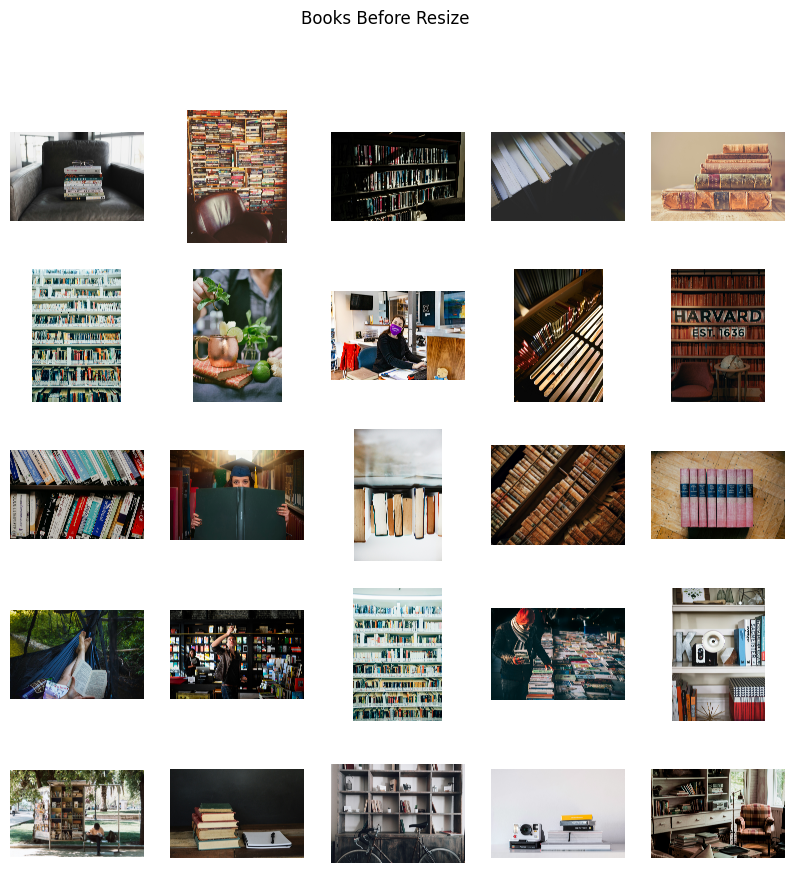

In [ ]:
def display_images_from_list(images, title, labels=None):
    if labels:
        combined = list(zip(images, labels))
        random.shuffle(combined)
        images, labels = zip(*combined)
    else:
        labels = [None] * len(images)

    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    fig.suptitle(title)

    for i, (ax, img) in enumerate(zip(axes.flatten(), images[:25])):
        ax.imshow(img)
        if labels:
            ax.set_title(labels[i], fontsize=8)
        ax.axis('off')

    plt.show()

display_images_from_list(books_orig_size, 'Books Before Resize')

### Image Resize

In [ ]:
def Img_Resize(image_list, image_type, output_size=(256, 256)):
    # New size of images
    output_size = (256, 256)
    # Labels for classes
    type_dict = {'book': 'book', 'chair': 'furniture', 'table': 'furniture', 'fridge': 'furniture', 'shoe': "shoe"}
    labels = {f"{image_type}_{i}": type_dict[image_type] for i in range(1, len(image_list) + 1)}
    resized_images = []

    for img in image_list:
        try:
            resized_img = img.resize(output_size)
            resized_images.append(resized_img)
        except Exception as e:
            print(f"Error resizing image: {e}")

    return resized_images, labels

In [ ]:
books, books_labels = Img_Resize(books_orig_size, 'book')
books, books_labels = books[:50], dict(itertools.islice(books_labels.items(), 50))

shoes, shoes_labels = Img_Resize(shoes_orig_size, 'shoe')
shoes, shoes_labels = shoes[:50], dict(itertools.islice(shoes_labels.items(), 50))

chairs, chairs_labels = Img_Resize(chairs_orig_size, 'chair')
chairs, chairs_labels = chairs[:17], dict(itertools.islice(chairs_labels.items(), 17))

fridges, fridges_labels = Img_Resize(fridges_orig_size, 'fridge')
fridges, fridges_labels = fridges[:16], dict(itertools.islice(fridges_labels.items(), 16))

tables, tables_labels = Img_Resize(tables_orig_size, 'table')
tables, tables_labels = tables[:17], dict(itertools.islice(tables_labels.items(), 17))

In [ ]:
# furniture list is a combination of chairs, fridges and tables
furniture = chairs + fridges + tables
furniture_labels = {}
furniture_labels.update(chairs_labels)
furniture_labels.update(fridges_labels)
furniture_labels.update(tables_labels)

In [ ]:
print(furniture_labels)

{'chair_1': 'furniture', 'chair_2': 'furniture', 'chair_3': 'furniture', 'chair_4': 'furniture', 'chair_5': 'furniture', 'chair_6': 'furniture', 'chair_7': 'furniture', 'chair_8': 'furniture', 'chair_9': 'furniture', 'chair_10': 'furniture', 'chair_11': 'furniture', 'chair_12': 'furniture', 'chair_13': 'furniture', 'chair_14': 'furniture', 'chair_15': 'furniture', 'chair_16': 'furniture', 'chair_17': 'furniture', 'fridge_1': 'furniture', 'fridge_2': 'furniture', 'fridge_3': 'furniture', 'fridge_4': 'furniture', 'fridge_5': 'furniture', 'fridge_6': 'furniture', 'fridge_7': 'furniture', 'fridge_8': 'furniture', 'fridge_9': 'furniture', 'fridge_10': 'furniture', 'fridge_11': 'furniture', 'fridge_12': 'furniture', 'fridge_13': 'furniture', 'fridge_14': 'furniture', 'fridge_15': 'furniture', 'fridge_16': 'furniture', 'table_1': 'furniture', 'table_2': 'furniture', 'table_3': 'furniture', 'table_4': 'furniture', 'table_5': 'furniture', 'table_6': 'furniture', 'table_7': 'furniture', 'table_8

### Display Images with assigned Labels

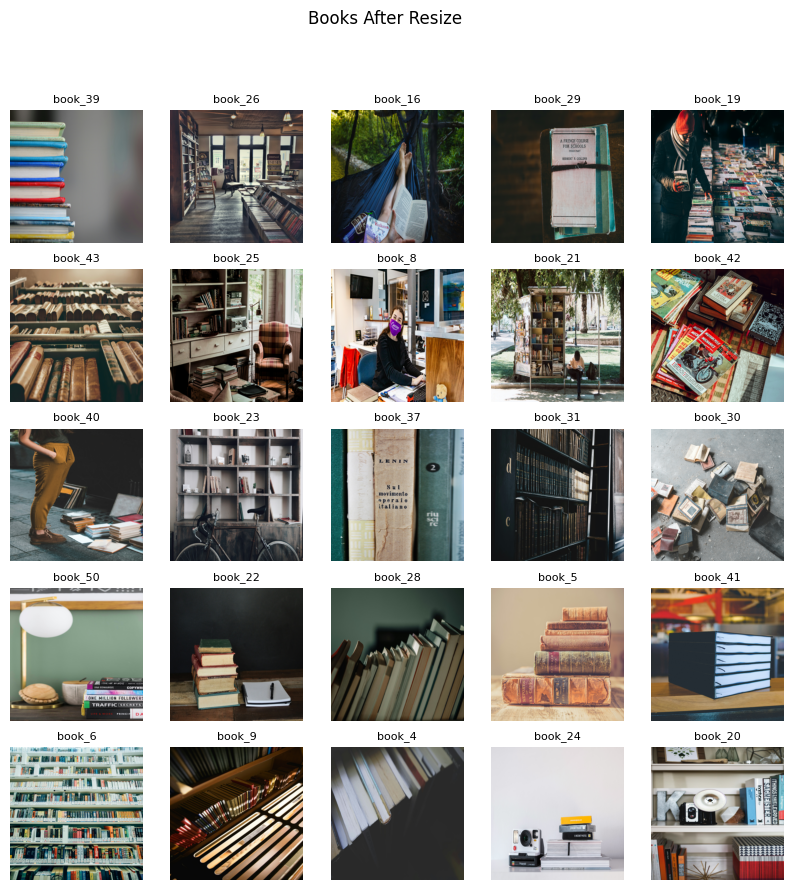

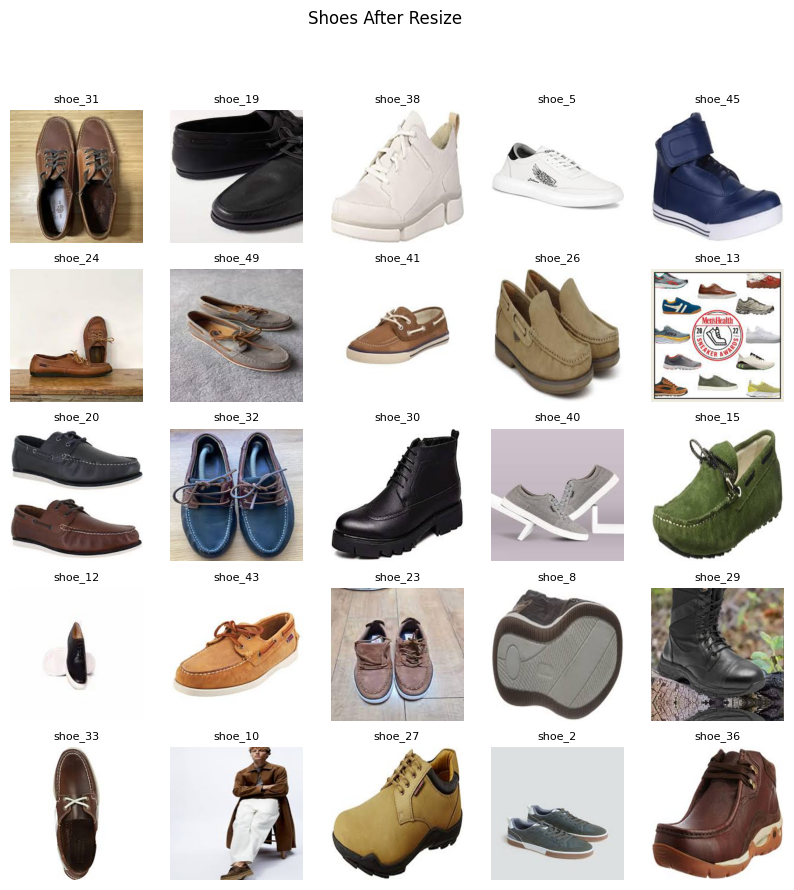

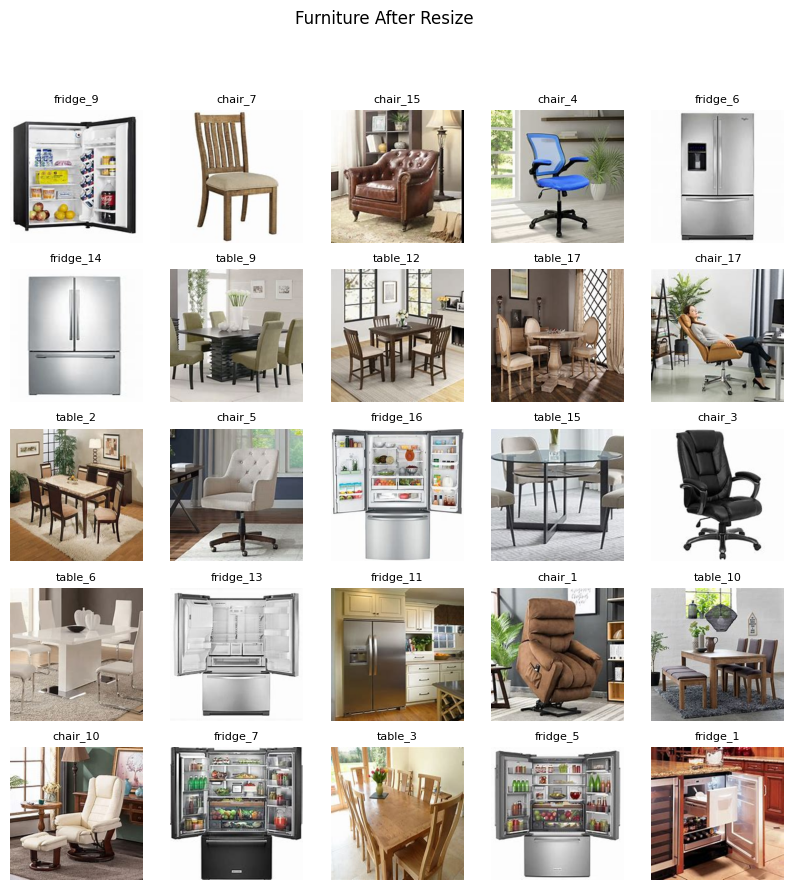

In [ ]:
display_images_from_list(books, 'Books After Resize', books_labels)
display_images_from_list(shoes, 'Shoes After Resize', shoes_labels)
display_images_from_list(furniture, 'Furniture After Resize', furniture_labels)

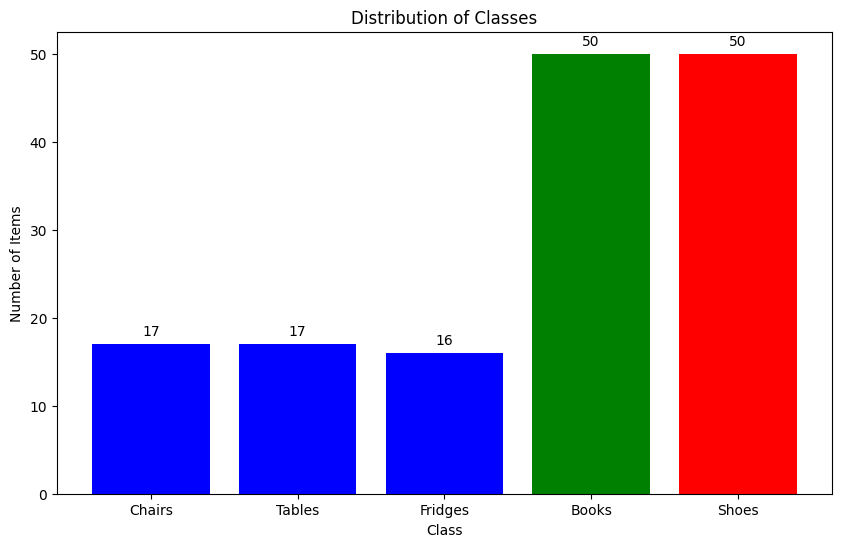

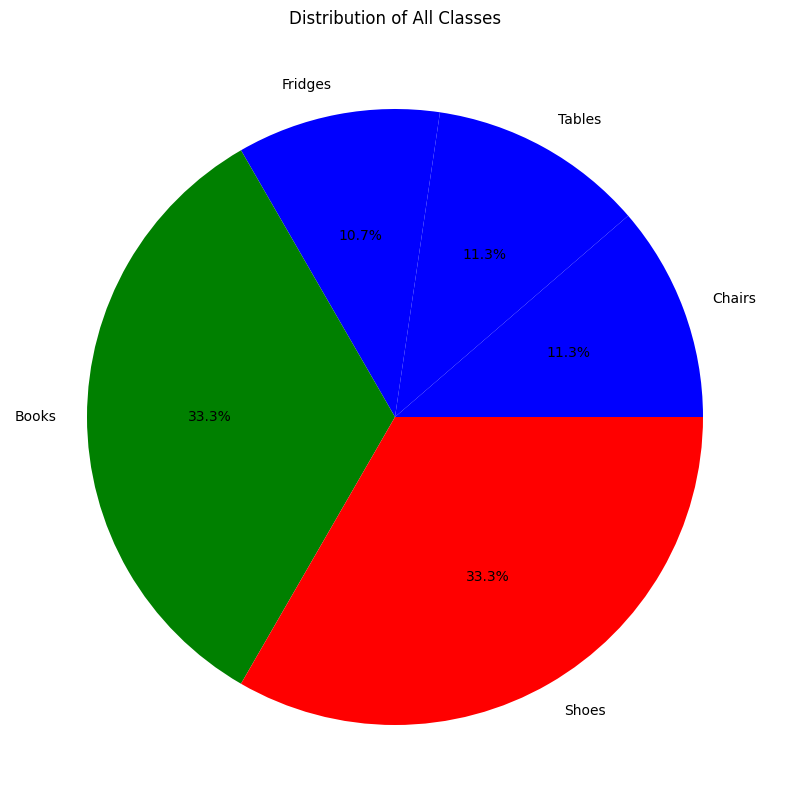

In [ ]:
# Count the number of items in each class
# Combine all class counts for a single pie chart
all_counts = {
    'Chairs': len(chairs),
    'Tables': len(tables),
    'Fridges': len(fridges),
    'Books': len(books),
    'Shoes': len(shoes)
}

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(all_counts.keys(), all_counts.values(), color=['blue', 'blue', 'blue', 'green', 'red'])
# Add data labels to the columns
for i, (key, value) in enumerate(all_counts.items()):
    plt.text(i, value + 1, str(value), ha='center')

plt.xlabel('Class')
plt.ylabel('Number of Items')
plt.title('Distribution of Classes')
plt.figure(figsize=(10, 10))
plt.pie(all_counts.values(), labels=all_counts.keys(), autopct='%1.1f%%', colors=['blue', 'blue', 'blue', 'green', 'red'])
plt.title('Distribution of All Classes')
plt.show()

### Split Data

In [ ]:
all_images = furniture + shoes + books
all_labels_list = list(furniture_labels.values()) + list(shoes_labels.values()) + list(books_labels.values())

classes = np.array_split(all_images, 3)
labels = np.array_split(all_labels_list, 3)

num_test, num_val = 7, 7
num_train = 50 - num_test - num_val

# Create the splits
train_images = sum([list(cls[:num_train]) for cls in classes], [])
train_labels = sum([list(lbl[:num_train]) for lbl in labels], [])
val_images = sum([list(cls[num_train:num_train + num_val]) for cls in classes], [])
val_labels = sum([list(lbl[num_train:num_train + num_val]) for lbl in labels], [])
test_images = sum([list(cls[num_train + num_val:]) for cls in classes], [])
test_labels = sum([list(lbl[num_train + num_val:]) for lbl in labels], [])

# Randomize train data
combined = list(zip(train_images, train_labels))
random.shuffle(combined)
train_images, train_labels = zip(*combined)
train_images = list(train_images)
train_labels = list(train_labels)

print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")
print(f"Test set size: {len(test_images)}")

Training set size: 108
Validation set size: 21
Test set size: 21


### Data Statistics

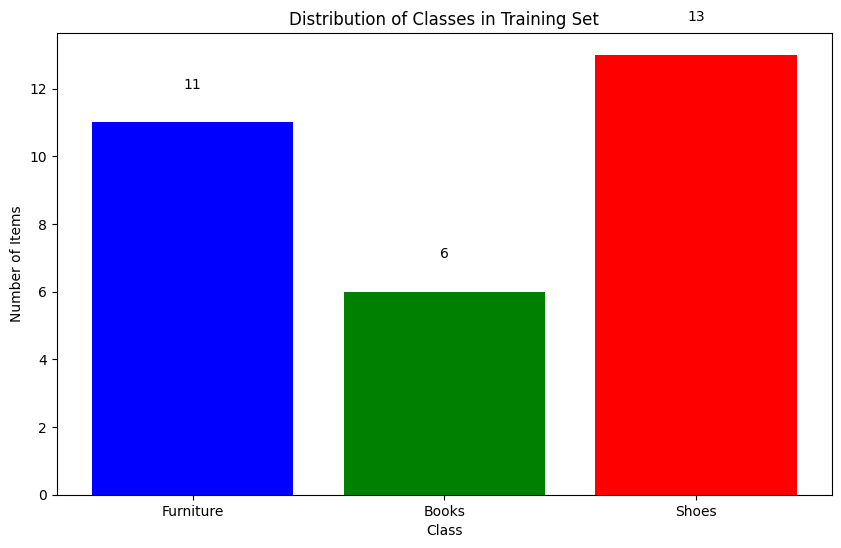

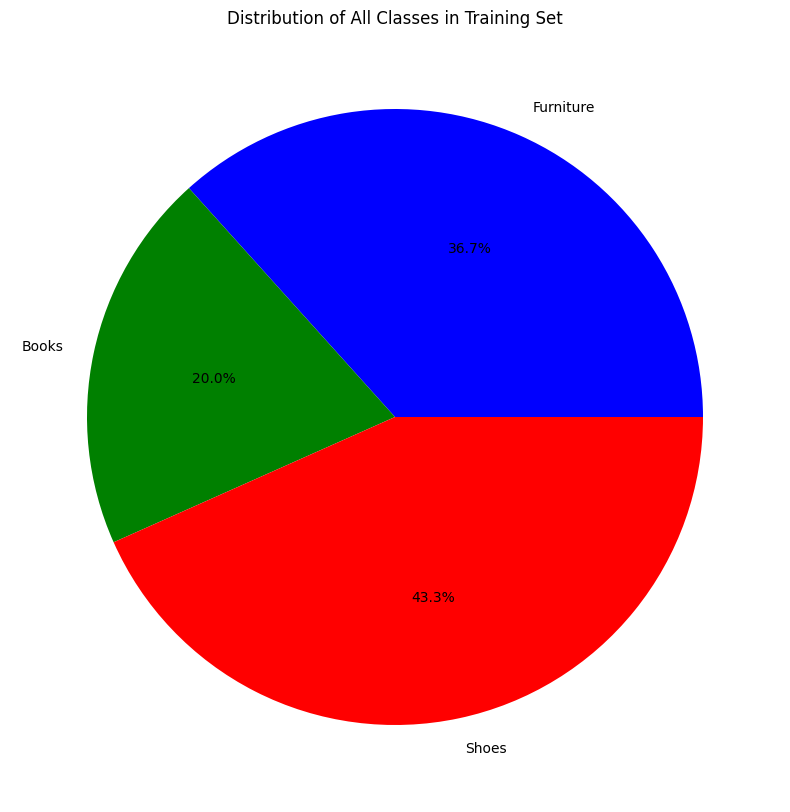

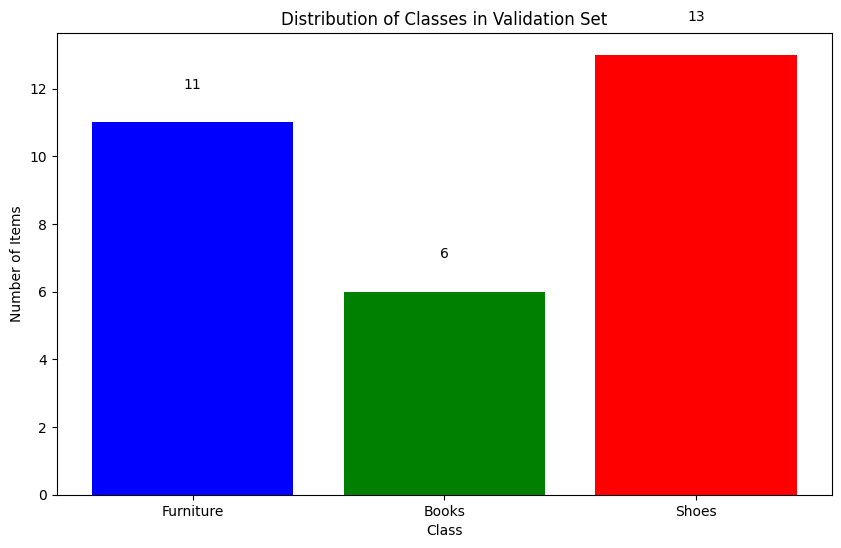

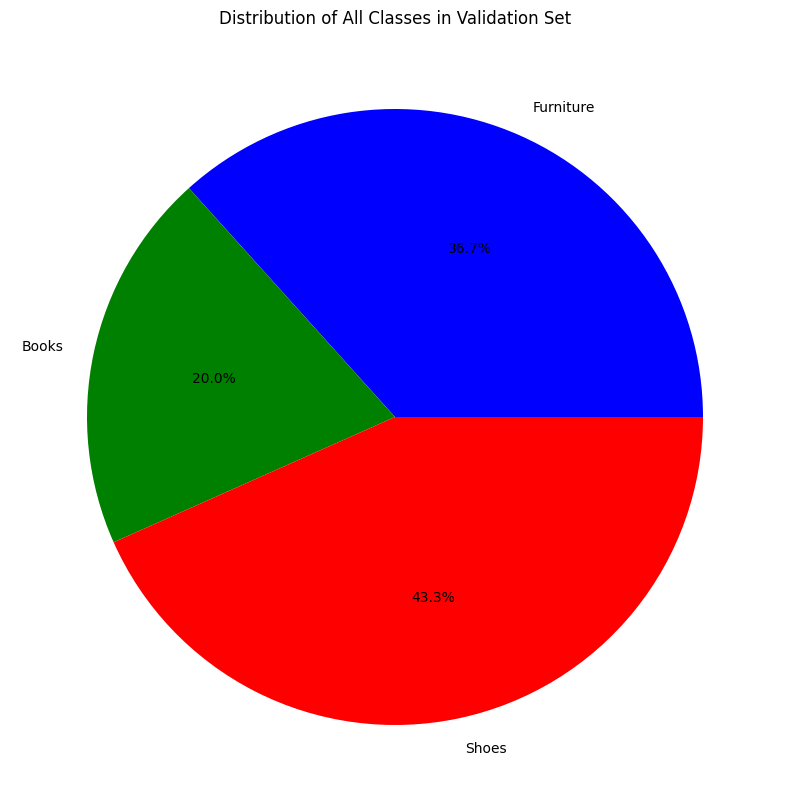

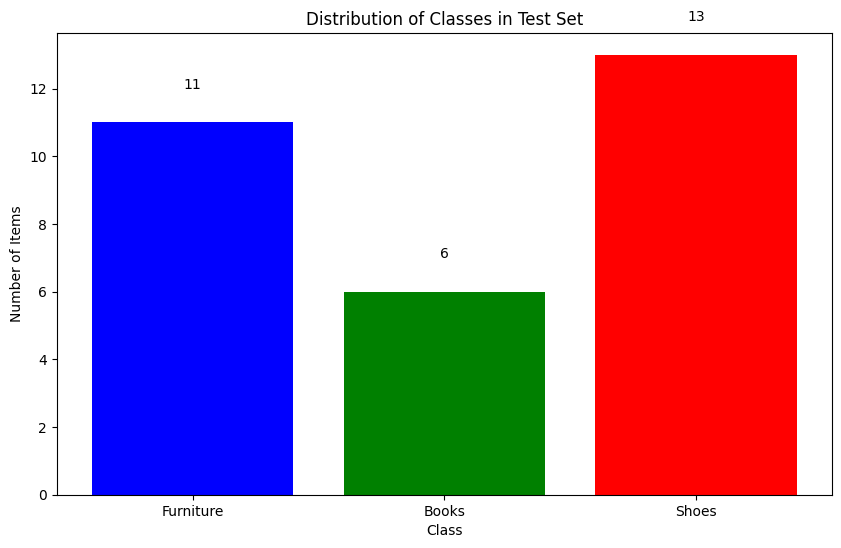

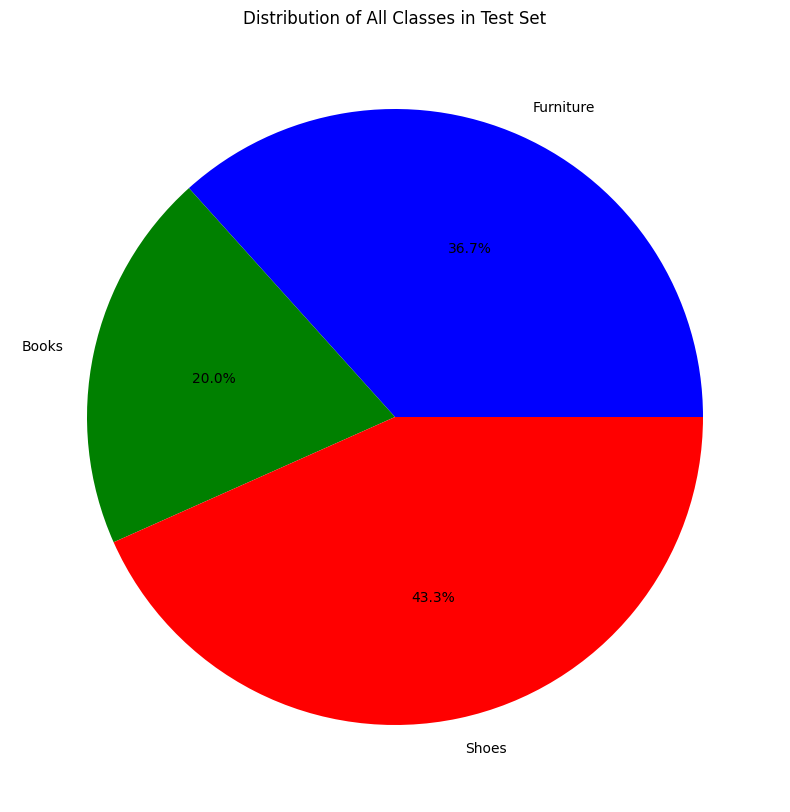

In [ ]:
train_counts = {
    'Furniture': sum(1 for label in test_labels if label == 'furniture'),
    'Books': sum(1 for label in test_labels if label == 'book'),
    'Shoes': sum(1 for label in test_labels if label == 'shoe')
}

# Plot the distribution for the training set
plt.figure(figsize=(10, 6))
plt.bar(train_counts.keys(), train_counts.values(), color=['blue', 'green', 'red'])
# Add data labels to the columns
for i, (key, value) in enumerate(train_counts.items()):
    plt.text(i, value + 1, str(value), ha='center')

plt.xlabel('Class')
plt.ylabel('Number of Items')
plt.title('Distribution of Classes in Training Set')
plt.figure(figsize=(10, 10))
plt.pie(train_counts.values(), labels=train_counts.keys(), autopct='%1.1f%%', colors=['blue', 'green', 'red'])
plt.title('Distribution of All Classes in Training Set')
plt.show()

# Count the number of items in each class in the validation set
val_counts = {
    'Furniture': sum(1 for label in test_labels if label == 'furniture'),
    'Books': sum(1 for label in test_labels if label == 'book'),
    'Shoes': sum(1 for label in test_labels if label == 'shoe')
}

# Plot the distribution for the validation set
plt.figure(figsize=(10, 6))
plt.bar(val_counts.keys(), val_counts.values(), color=['blue', 'green', 'red'])
# Add data labels to the columns
for i, (key, value) in enumerate(val_counts.items()):
    plt.text(i, value + 1, str(value), ha='center')

plt.xlabel('Class')
plt.ylabel('Number of Items')
plt.title('Distribution of Classes in Validation Set')
plt.figure(figsize=(10, 10))
plt.pie(val_counts.values(), labels=val_counts.keys(), autopct='%1.1f%%', colors=['blue', 'green', 'red'])
plt.title('Distribution of All Classes in Validation Set')
plt.show()

# Count the number of items in each class in the test set
test_counts = {
    'Furniture': sum(1 for label in test_labels if label == 'furniture'),
    'Books': sum(1 for label in test_labels if label == 'book'),
    'Shoes': sum(1 for label in test_labels if label == 'shoe')
}

# Plot the distribution for the test set
plt.figure(figsize=(10, 6))
plt.bar(test_counts.keys(), test_counts.values(), color=['blue', 'green', 'red'])
# Add data labels to the columns
for i, (key, value) in enumerate(test_counts.items()):
    plt.text(i, value + 1, str(value), ha='center')

plt.xlabel('Class')
plt.ylabel('Number of Items')
plt.title('Distribution of Classes in Test Set')
plt.figure(figsize=(10, 10))
plt.pie(test_counts.values(), labels=test_counts.keys(), autopct='%1.1f%%', colors=['blue', 'green', 'red'])
plt.title('Distribution of All Classes in Test Set')
plt.show()

##Baseline models

###Random choosing

In [ ]:
# Define the classes
classes = list(set(val_labels))
num_samples = len(train_images)

# Function to create random baseline predictions
def random_baseline_predictions(num_samples):
    """
    Generate random predictions for a given number of samples.

    Parameters:
    num_samples (int): Number of predictions to generate.

    Returns:
    list: Randomly selected classes for each sample.
    """
    return [random.choice(classes) for _ in range(num_samples)]

Accuracy: 0.39


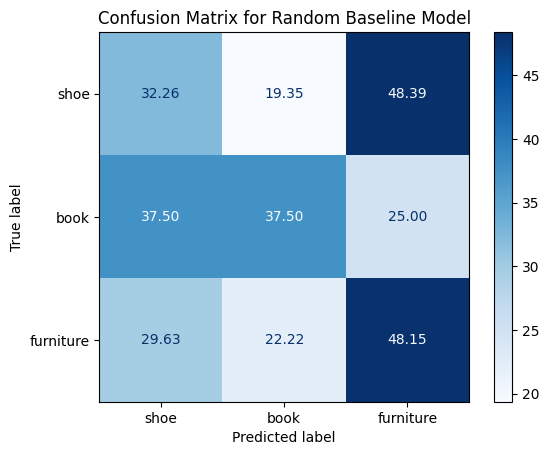

In [ ]:
# Example usage
true_labels = train_labels
random_predictions = random_baseline_predictions(num_samples)

# Convert the random predictions and true labels to arrays for evaluation
random_predictions_array = np.array(random_predictions)
true_labels_array = np.array(true_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels_array, random_predictions_array)
print(f"Accuracy: {accuracy:.2f}")

# Generate and display the confusion matrix
# Generate and display the confusion matrix with percentages
conf_matrix = confusion_matrix(true_labels_array, random_predictions_array, labels=classes)
conf_matrix_percent = np.nan_to_num(conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percent, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title('Confusion Matrix for Random Baseline Model')
plt.show()

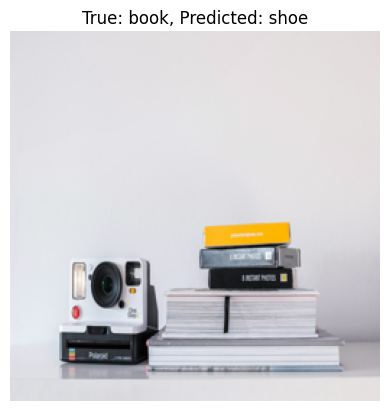

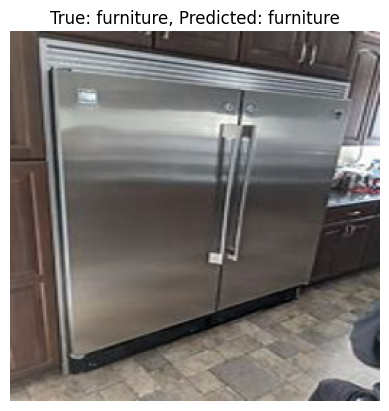

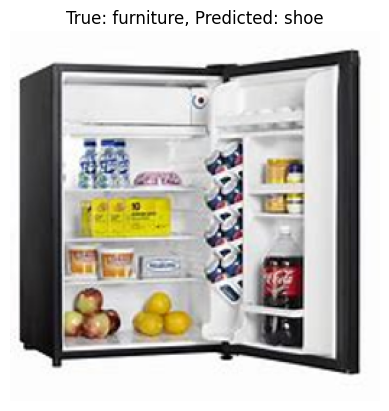

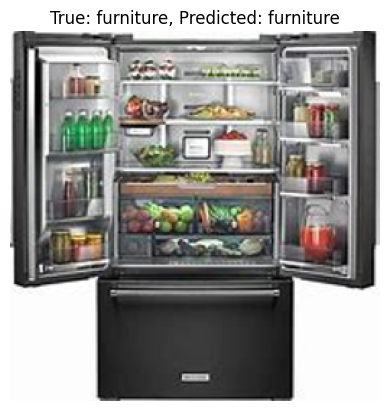

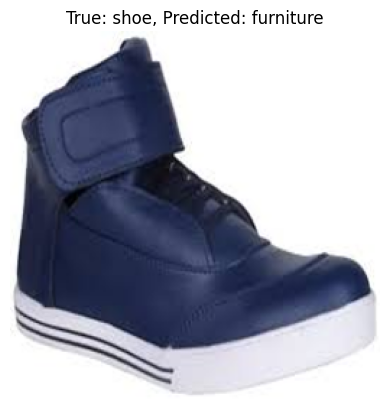

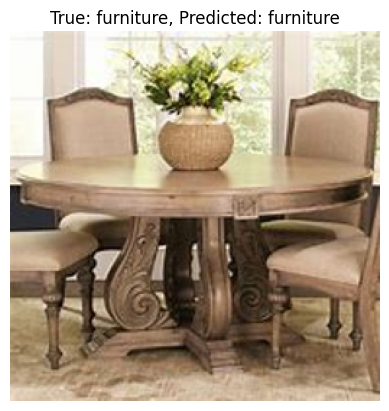

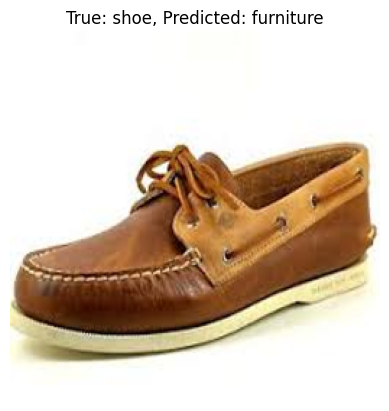

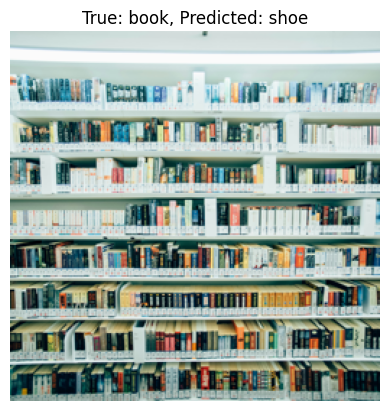

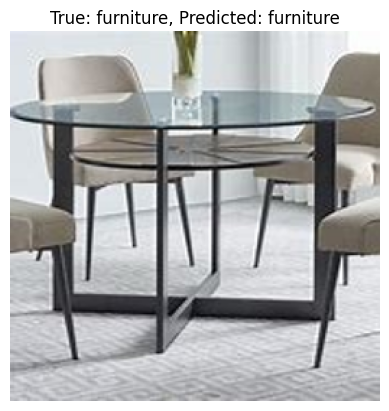

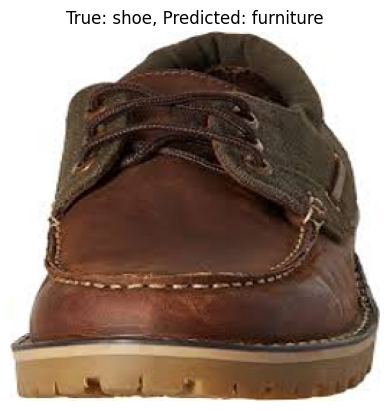

In [ ]:
# Display some example images with predicted and true labels (mock images for demonstration)
def display_predictions(num_samples_to_show=10):
    """
    Display sample predictions with true labels.

    Parameters:
    num_samples_to_show (int): Number of samples to display.
    """
    for i in range(num_samples_to_show):
        true_label = true_labels[i]
        predicted_label = random_predictions[i]
        # Mock image (in a real scenario, replace this with actual image data)
        image = train_images[i]
        plt.imshow(image)
        plt.title(f"True: {true_label}, Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

# Display some sample predictions
display_predictions()

###Baseline neural network model

In [ ]:
# Baseline Convolutional Neural Network model
def create_baseline_cnn(input_shape=(256, 256, 3), num_classes=3):
    """
    Create a simple baseline CNN model.

    Parameters:
    input_shape (tuple): Shape of the input images.
    num_classes (int): Number of output classes.

    Returns:
    model: A compiled CNN model.
    """
    model = Sequential()
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and summarize the baseline CNN model
baseline_cnn = create_baseline_cnn()
#baseline_cnn.summary()

# Convert true labels to categorical for training (in a real scenario, use actual labels)
true_labels_categorical = to_categorical([classes.index(label) for label in true_labels], num_classes=len(classes))

# Convert images to numpy array for training
train_images = np.array(train_images)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the baseline CNN model (for demonstration purposes, using mock data)
baseline_cnn.fit(train_images, true_labels_categorical, epochs=10, batch_size=16)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.4189 - loss: 2563.4675
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.3408 - loss: 6.2430
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6680 - loss: 0.6379
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8792 - loss: 0.3166
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.9000 - loss: 0.1511
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9765 - loss: 0.0998
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9764 - loss: 0.0826
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9546 - loss: 0.5390
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9928 - loss: 0.1520
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9919 - loss: 0.0484


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Trained Model Accuracy: 0.43


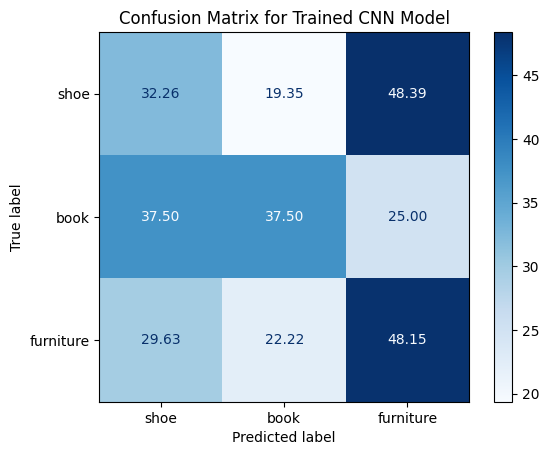

In [ ]:
test_images = np.array(test_images)
# Evaluate the trained model
predictions = baseline_cnn.predict(test_images)
predicted_labels = [classes[np.argmax(pred)] for pred in predictions]

# Calculate accuracy for the trained model
trained_accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Trained Model Accuracy: {trained_accuracy:.2f}")

# Generate and display the confusion matrix for the trained model
trained_conf_matrix = confusion_matrix(test_labels, predicted_labels, labels=classes)
trained_conf_matrix_percent = np.nan_to_num(conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100)

trained_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percent, display_labels=classes)
trained_disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title('Confusion Matrix for Trained CNN Model')
plt.show()

In [ ]:
# it is clear, that the model was overfitting while training (99% accuracy on training data, it is only 43% on test data)
# Display some example images with predicted and true labels for the trained model
def display_trained_predictions(num_samples_to_show=5):
    """
    Display sample predictions with true labels for the trained model.

    Parameters:
    num_samples_to_show (int): Number of samples to display.
    """
    for i in range(num_samples_to_show):
        true_label = test_labels[i]
        predicted_label = predicted_labels[i]
        # Display the actual image from the array
        image = test_images[i]
        plt.imshow(image)
        plt.title(f"True: {true_label}, Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

# Display some sample predictions for the trained model
display_trained_predictions()

## Improved neural network model

### old cnn

In [ ]:
def create_improved_cnn(input_shape=(256, 256, 3), num_classes=3):
    model = Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_improved_cnn()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Image Augmentation

In [ ]:
# Image augmentation
datagen = ImageDataGenerator(
    rotation_range=20,       # Random rotation between 0-20 degrees
    width_shift_range=0.2,   # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,         # Shear intensity
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest',     # Fill mode for pixels outside boundaries
    rescale=1.0 / 255.0)     # Normalize pixel values to [0, 1]

val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
classes = ['book', 'furniture', 'shoe']
batch_size = 9

train_images = np.array(train_images)
train_labels_categorical = to_categorical([classes.index(label) for label in train_labels], num_classes=len(classes))

val_images = np.array(val_images)
val_labels_categorical = to_categorical([classes.index(label) for label in val_labels], num_classes=len(classes))

train_generator = datagen.flow(train_images, train_labels_categorical, batch_size=batch_size)
val_generator = val_datagen.flow(val_images, val_labels_categorical, batch_size=batch_size)

# Define EarlyStopping to stop training when val_accuracy >= 0.70
early_stopping = EarlyStopping(
    monitor='val_accuracy',          # Monitor validation accuracy
    mode='max',                      # Stop when monitored value is at its maximum
    patience=0,                      # Stop as soon as the condition is met
    restore_best_weights=True,       # Restore the best weights when stopping
    baseline=0.70                    # Minimum value of val_accuracy to trigger stopping
)

In [ ]:
unique_classes = np.unique(train_labels)  # Find unique class labels
class_weights = compute_class_weight(
    class_weight='balanced',  # Balance the weights inversely proportional to class frequencies
    classes=unique_classes,
    y=train_labels
)

# Convert to a dictionary for use in Keras
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict[1] *= 0.5

In [ ]:
history = model.fit(train_generator, validation_data=val_generator, epochs=17, class_weight=class_weights_dict)

Epoch 1/17
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 581ms/step - accuracy: 0.7765 - loss: 0.4801 - val_accuracy: 0.7619 - val_loss: 0.6329
Epoch 2/17
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 684ms/step - accuracy: 0.7947 - loss: 0.3941 - val_accuracy: 0.7143 - val_loss: 0.5843
Epoch 3/17
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 534ms/step - accuracy: 0.7045 - loss: 0.4178 - val_accuracy: 0.8571 - val_loss: 0.5121
Epoch 4/17
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 641ms/step - accuracy: 0.7850 - loss: 0.3941 - val_accuracy: 0.8095 - val_loss: 0.6007
Epoch 5/17
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 664ms/step - accuracy: 0.6278 - loss: 0.4305 - val_accuracy: 0.7619 - val_loss: 0.5388
Epoch 6/17
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 540ms/step - accuracy: 0.7765 - loss: 0.3180 - val_accuracy: 0.8095 - val_loss: 0.6403
Epoch 7/17
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 703ms/step - accuracy: 0.8197 - loss: 0.3368 - val_accuracy: 0.8095 - val_loss: 0.6798
Epoch 8/17
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 615ms/step - accuracy: 0.8238 - loss: 0.2832 - val_accuracy: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
Trained Model Accuracy: 0.81


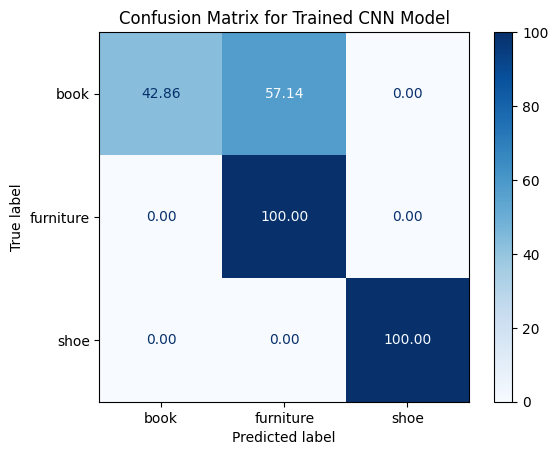

In [ ]:
test_images = np.array(test_images)
predictions = model.predict(test_images)
predicted_labels = [classes[np.argmax(pred)] for pred in predictions]

# Calculate accuracy for the trained model
trained_accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Trained Model Accuracy: {trained_accuracy:.2f}")

# Generate and display the confusion matrix for the trained model
trained_conf_matrix = confusion_matrix(test_labels, predicted_labels, labels=classes)
trained_conf_matrix_percent = np.nan_to_num(trained_conf_matrix / trained_conf_matrix.sum(axis=1, keepdims=True) * 100)

trained_disp = ConfusionMatrixDisplay(confusion_matrix=trained_conf_matrix_percent, display_labels=classes)
trained_disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.title('Confusion Matrix for Trained CNN Model')
plt.show()

In [ ]:
# Save the trained model to a file
model.save('MT_NHF_0_81.keras')

In [ ]:
model = models.load_model("MT_NHF_0_81.keras")